In [5]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import pandas as pd
from scipy import signal
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import os
from tqdm.notebook import tqdm

## Original Convolution Assumptions (REPLACED)

In [2]:
def trapezoid_impulse(t, tau, T1, T2):
    # T2 >= T1
    truncated_ramp = lambda t, T1: np.concatenate((t[:np.argmin(np.abs(t-T1))+1], 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T1))-1)))
    moving_average = lambda t, T2: np.concatenate((np.ones(np.argmin(np.abs(t-T2))+1), 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T2))-1)))
    h1, h2 = truncated_ramp(t, T1), moving_average(t, T2)
    h1_t_T2, h2_t_T1 = np.roll(truncated_ramp(t, T1), T2), np.roll(moving_average(t, T2), T1)
    h = h1 + tau*h2 + (T1-tau)*h2_t_T1 - h1_t_T2
    return h

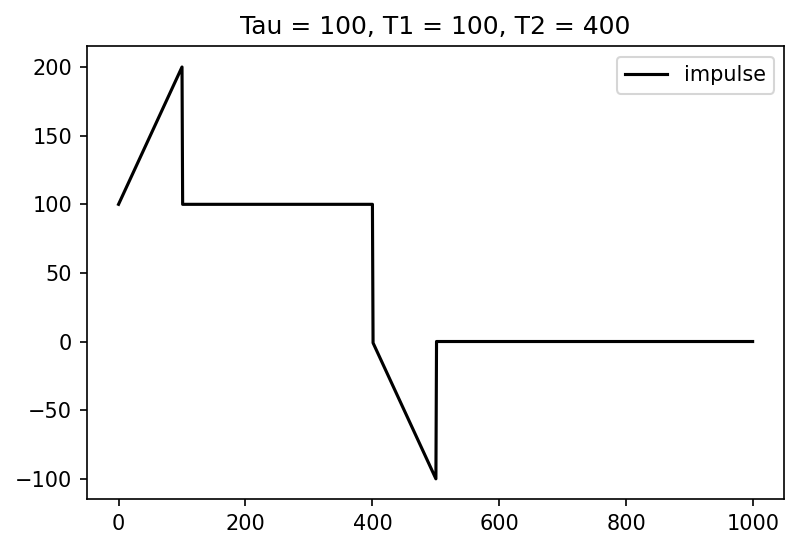

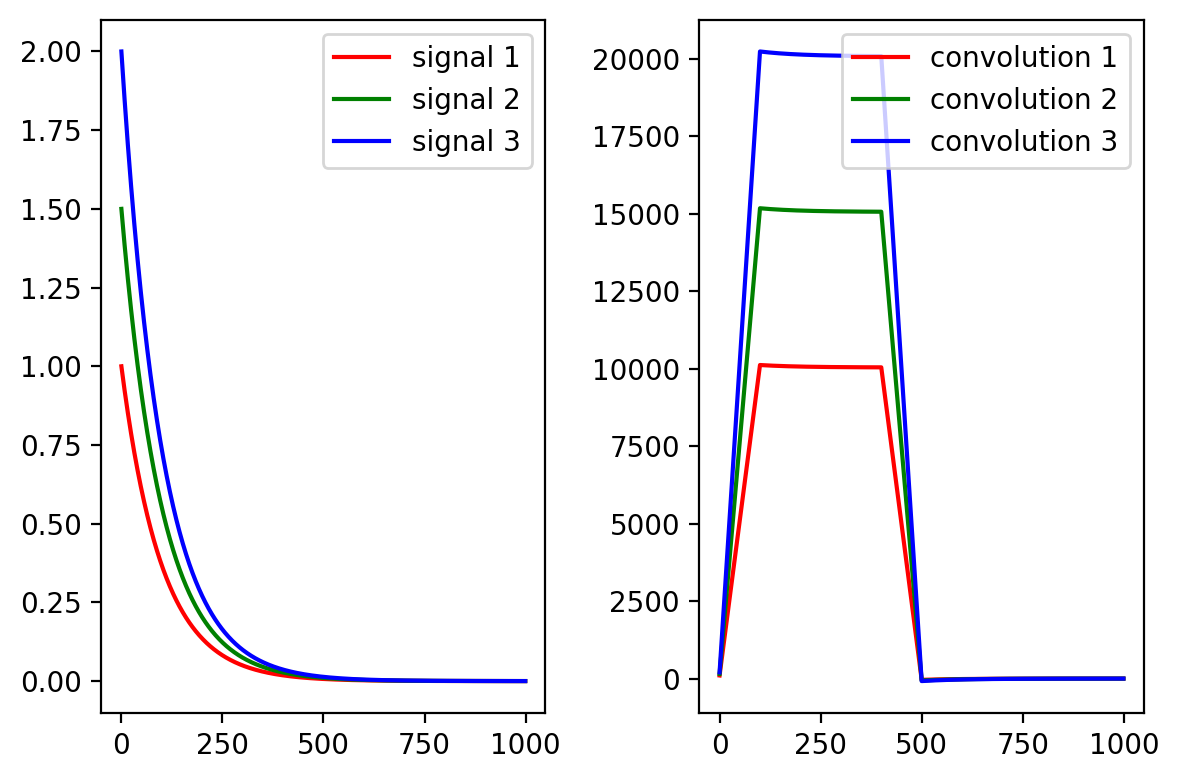

In [3]:
ln = 1000
t = np.linspace(0, 1000, ln)

test_exp = np.exp(-t/100)
test_exp2 = 1.5*np.exp(-t/100)
test_exp3 = 2*np.exp(-t/100)

tau, T1, T2 = 100, 100, 400
test = trapezoid_impulse(t, tau, T1, T2)

fig = plt.figure(dpi=150)
plt.plot(test, color='black', label='impulse')
plt.title('Tau = {}, T1 = {}, T2 = {}'.format(tau, T1, T2))
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
ax1.plot(test_exp, c='red', label='signal 1')
ax1.plot(test_exp2, c='green', label='signal 2')
ax1.plot(test_exp3, c='blue', label='signal 3')
ax1.legend()

ax2.plot(np.convolve(test_exp, test)[:ln], c='red', label='convolution 1')
ax2.plot(np.convolve(test_exp2, test)[:ln], c='green', label='convolution 2')
ax2.plot(np.convolve(test_exp3, test)[:ln], c='blue', label='convolution 3')
ax2.legend()
plt.tight_layout()
plt.show()

## New Trapezoidal Shaping Approach

In [65]:
def determine_rise(signal, sigma=8, window=20, offset=15):
    noise_samp = signal[:500]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    
    grad = np.gradient(np.where(signal > mean+sigma*std, signal, 0))
    
    grad_pos, grad_neg = np.argwhere(grad>2), np.argwhere(grad<-2)
    
    rise_start = 0
    for gp in grad_pos:
        close = False
        for gn in grad_neg:
            if np.abs(gp-gn) < window:
                close = True
        if not close:
            rise_start = gp
            break
    
    return int(rise_start-offset)

def delay_signal(signal, delay=2000, w=500):
    noise_samp = signal[:w]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    noise = np.random.normal(mean, 0.9*std, delay)
    return np.hstack([noise, signal])

def dkl(signal, i, k, l, w):
    signal = delay_signal(signal, delay=w)
    vj = signal[i+w:i+w+w]
    vjk = signal[i-k+w:i+w+w-k]
    vjl = signal[i-l+w:i+w+w-l]
    vjkl = signal[i-k-l+w:i+w+w-k-l]
    return vj - vjk - vjl + vjkl
    
def s(signal, start_rise, tau, peaking_time, gap_time, w=0):
    if w == 0:
        w = int(round(2.5*peaking_time+gap_time, 0))
    ss = []
    for j in range(w):
        if j == 0:
            ss.append(0)
        else:
            ss.append(ss[j-1]*(1+1/tau)+ dkl(signal, start_rise, peaking_time, peaking_time+gap_time, w)[j])
    return np.array(ss)

In [119]:
f = h5py.File('Data/Test-928/Th228-24in-20min.h5', 'r')

test_data = pd.DataFrame(f['raw_data'])
test_np = test_data.to_numpy()

sat_i = []
for i in range(len(test_np)):
    if test_np[i][1300] == 16383:
        sat_i.append(i)

print(len(test_np))

22981


In [128]:
datas = []

for i in range(27, 29):
    f = h5py.File('/Users/raptor/Research/python3316/Data/Test-928/Co60-36in-1min_{}.h5'.format(i), 'r')
    dataframe = pd.DataFrame(f['raw_data'])
    data_np = dataframe.to_numpy()
    
    datas.append(data_np)
merge_data = np.concatenate(datas)

fmerged = h5py.File('Data/Test-928/Co60-36in-2min.h5', 'w')
fmerged.create_dataset('raw_data', data=merge_data)

fmerged.close()

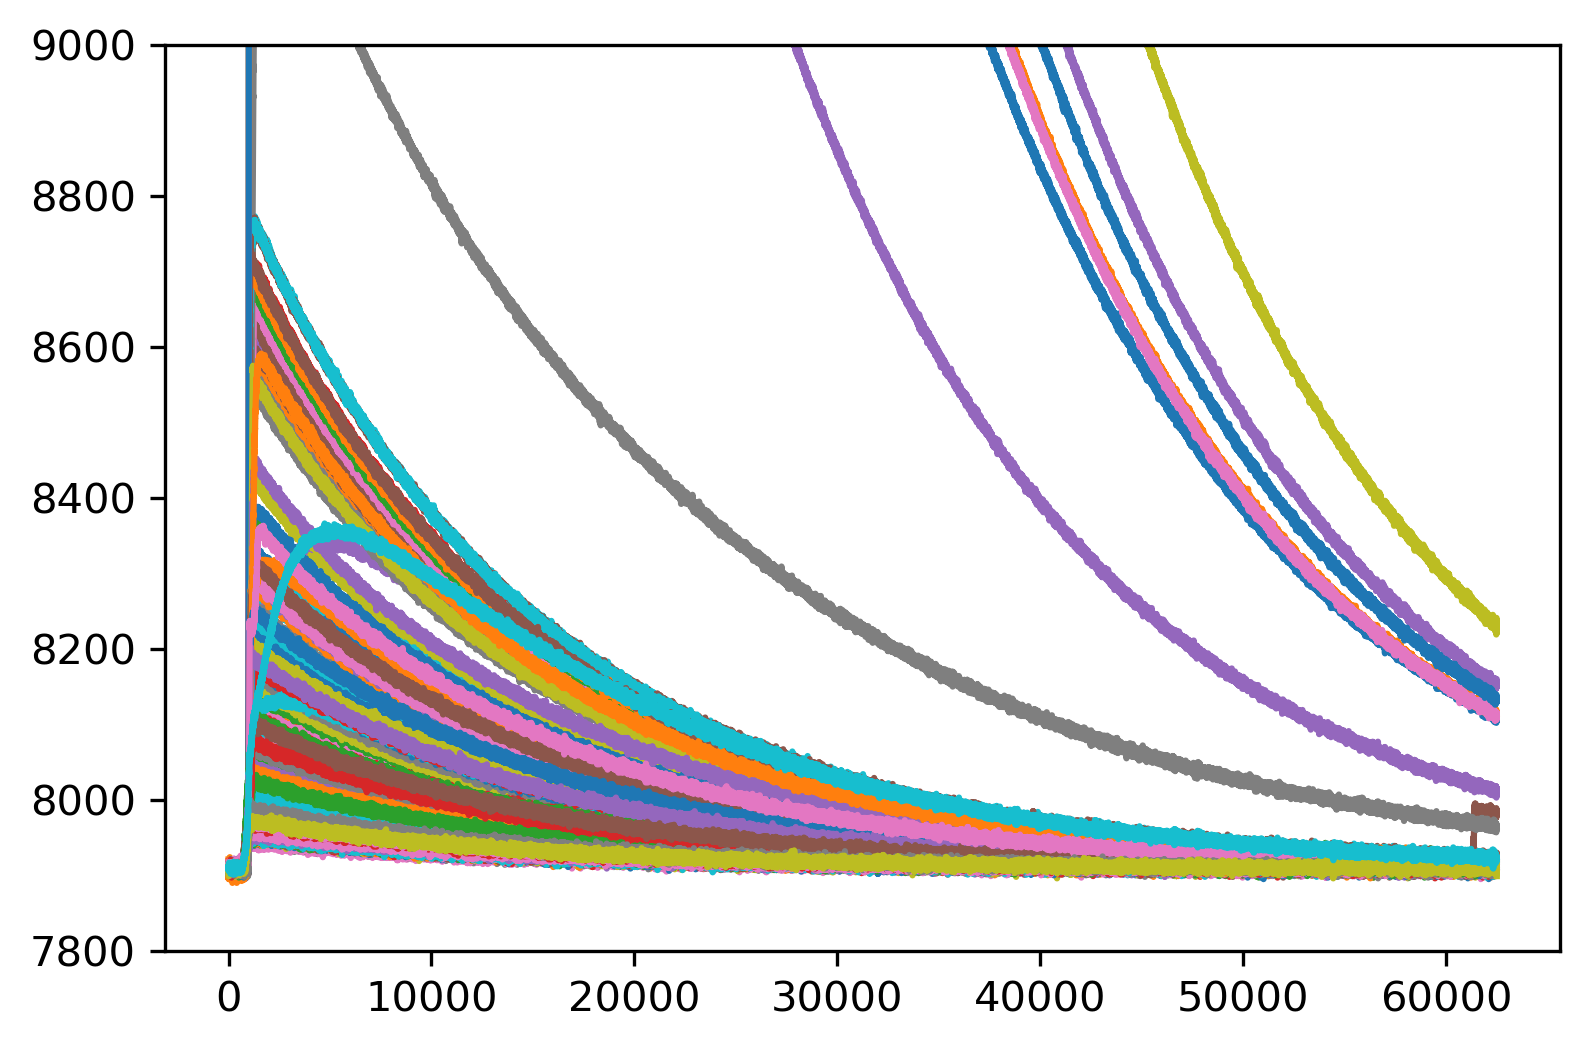

In [89]:
plt.figure(dpi=300)
for i in range(250):
    plt.plot(test_np[i])
plt.ylim(7800, 9000)
plt.show()

In [120]:
ra = 51
peak, gap = 369, 200
traps = []
for i, pulse in enumerate(tqdm(test_np)):
    if i not in sat_i:
        fs = savgol_filter(pulse, ra, 0)
    
        trap = s(fs, determine_rise(fs), 15000, peak, gap)
        traps.append(trap)

  0%|          | 0/22981 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (695,) (1064,) 

-15

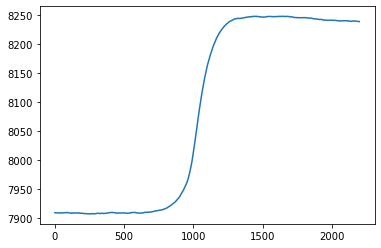

In [124]:
plt.plot(fs[:2200])
determine_rise(fs[:2200])

In [125]:
spectra = []

for trap in traps:
    if max(trap) < 365000:
        spectra.append(max(trap))

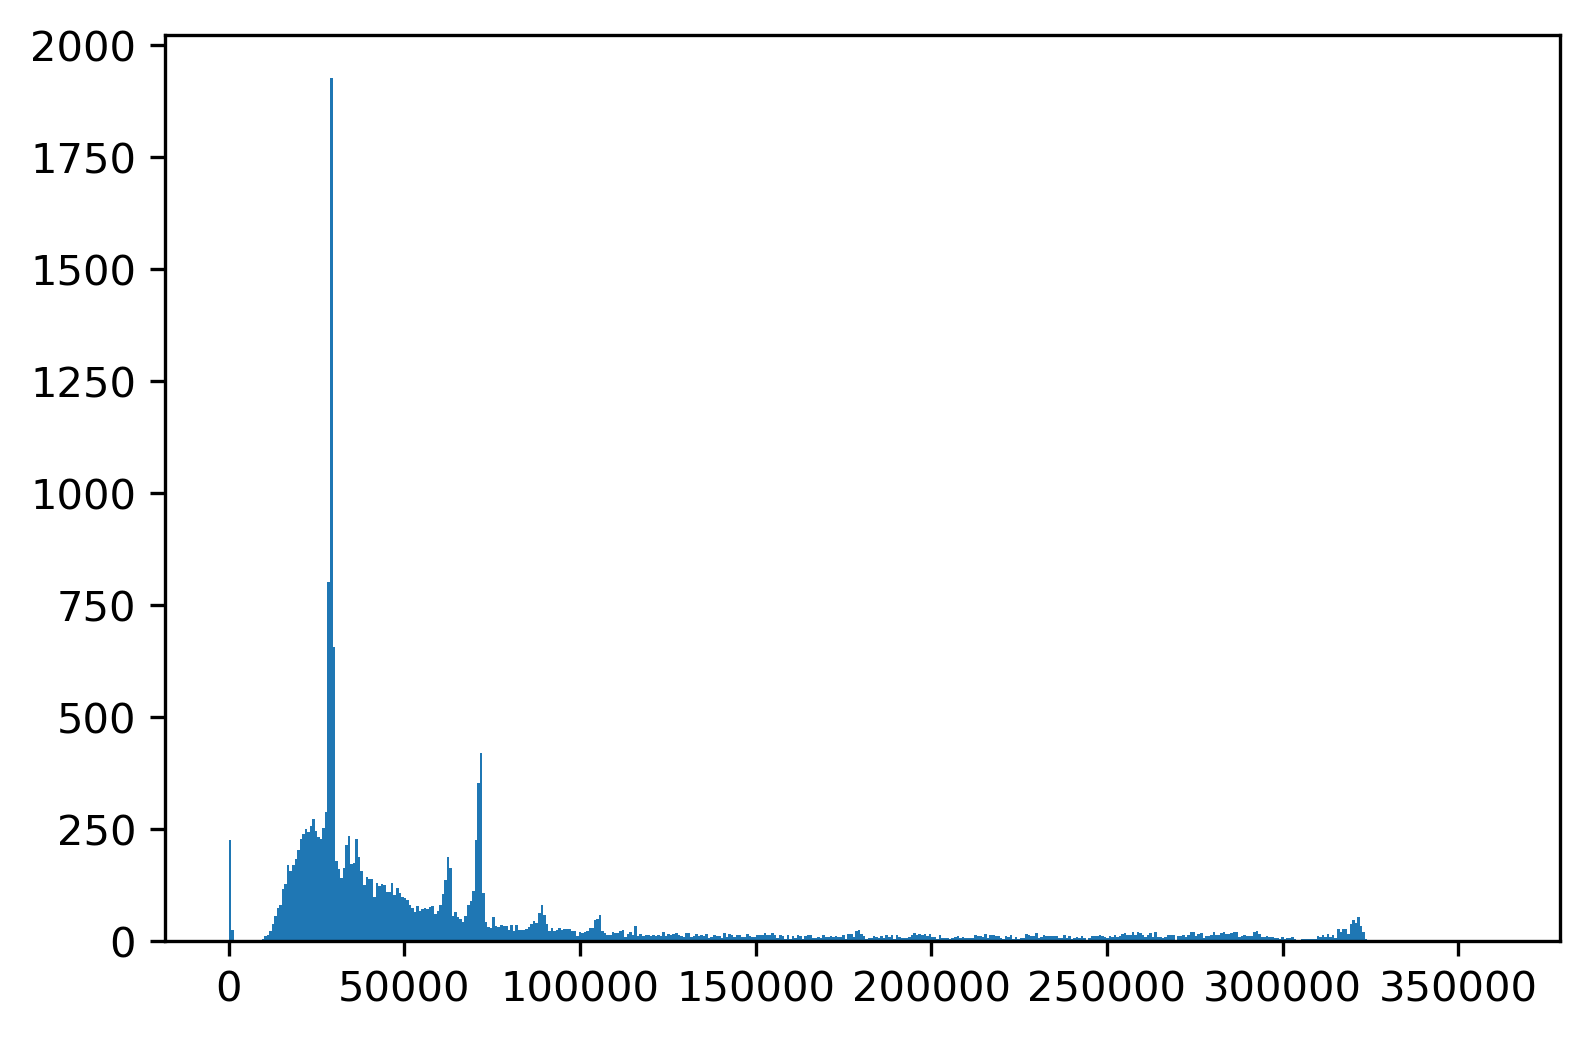

In [131]:
plt.figure(dpi=300)
plt.hist(spectra, bins=500)
#plt.semilogy()
plt.show()

In [30]:
def get_k(signal):
    end_index = np.argmax(signal)
    diff_list = []
    N = 0
    diff_array = np.array([signal[end_index] - signal[end_index - n] for n in range(end_index)])
    med = np.mean(diff_array[500:])
    for n in range(len(diff_array)):
        if diff_array[n]>0.9999998*med:
            N = n
            break
    return np.array([N, end_index])
    #return diff_array

In [34]:
ind, ra = 19, 51

ks2 = []
for i, pulse in enumerate(tqdm(test_np)):
    if i not in sat_i:
        fs = savgol_filter(pulse, ra, 0)

        gk = get_k(fs)
        
        ks2.append(gk[0])

  0%|          | 0/3162 [00:00<?, ?it/s]

In [64]:
round(2.5,0)

2.0

In [ ]:
fpath = 'Data/Test-928/'

d_names = os.listdir('/Users/raptor/Research/python3316/Data/Test-928/')
#print(d_names)

idata = 0
for i in d_names:
    if i.endswith('.h5'):
        print(fpath+i)
        f = h5py.File(fpath + i,'r')
        ievent_data = f['event_data']
        if idata==0:
            event_data = ievent_data.copy()
            idata += ievent_data.shape[0]
        else:
            event_data = np.append(event_data,ievent_data,axis=0)
            idata += ievent_data.shape[0]
            
fmerged = h5py.File(fpath+'Processed/old-meth-merged-background.h5', 'w')
fmerged.create_dataset('event_data', data=event_data)